# Lecture 2 : Neural Classifiers

## Word2vec Parameters

<p align="center">
    <img src="img/j/j4.png" alt="Word Vectors" width="500"/>
</p>

- The model we discussed in lec1 is a **Bag of Words** model. This is represented by the figure above.
  - It makes same predictions at each position
  - Doesn't pay attention to word order or position
- Word2vec maximizes objective function by putting similar words nearby in a vector space
  - Samsung & Nokia are close to each other in the vector space

## Optimization : Gradient Descent

- **Essence** : How do we learn good word vectors?
- **Gradient Descent** is used to minimize $ J(\theta) $ by changing $ \theta $
  - **Main Idea** : from the current value of $ \theta $, calculate the gradient of $ J(\theta) $, then take a small step in the direction of the negative gradient. Repeat.

<p align="center">
    <img src="img/j/j5.png" alt="Word Vectors" width="500"/>
</p>

- If the step size is too small, it takes too long.
- If the step size is too big, the graph can diverge.

### Gradient Descent

Essence : GD is very expensive. SGD is used instead.

Gradient descent is an optimization algorithm used to minimize the cost function $ J(\theta) $. The update equation in matrix notation is as follows:

$$
  \theta_{\text{new}} = \theta_{\text{old}} - \alpha \nabla_{\theta} J(\theta)
  
$$

  - $ \theta_{\text{new}} $: The new values of the parameters after the update.
  - $ \theta_{\text{old}} $: The old values of the parameters before the update.
  - $ \alpha $: The learning rate (also known as the step size), which controls the size of the update. A smaller value of $ \alpha $ leads to slower convergence, while a larger value could cause the algorithm to overshoot the minimum.
  - $ \nabla_{\theta} J(\theta) $: The gradient of the cost function with respect to the parameters $ \theta $. The gradient gives the direction in which the cost function increases the most, and moving in the opposite direction reduces the cost.

**Problem** : $ J(\theta) $ is a function for all windows in the corpus (often, billions) -> Extremely expensive to compute.

**Solution** : Stochastic Gradient Descent : simply take one or a small batch of 32 center words and make an estimate of the gradient based on them -> This will be noisy, but by using the estimate of the gradient, the $ \theta $ parameter can be updated.

Epoch 0: Loss = 0.9727
Epoch 10: Loss = 1.1104
Epoch 20: Loss = 0.9602
Epoch 30: Loss = 1.0543
Epoch 40: Loss = 1.0423


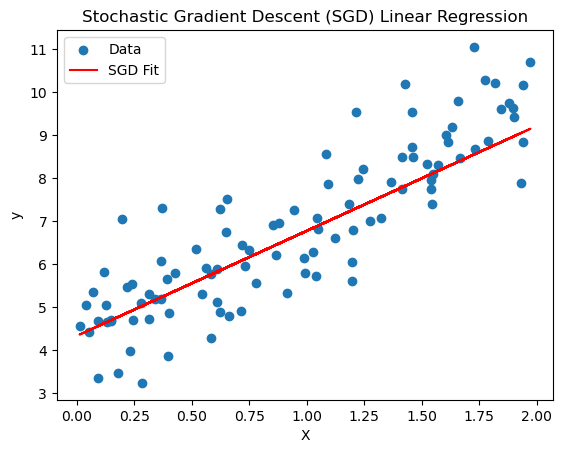

In [1]:
# SGD Algorithm Example

import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data (y = 2x + 1 with noise)
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)  # Linear relationship with some noise

# Initialize parameters (random values)
theta = np.random.randn(2, 1)  # [theta_0 (bias), theta_1]
learning_rate = 0.1
epochs = 50
m = len(X)

# Add bias term (x_0 = 1 for all samples)
X_b = np.c_[np.ones((m, 1)), X]  # Shape: (100, 2)

# SGD function
def stochastic_gradient_descent(X, y, theta, learning_rate, epochs):
    for epoch in range(epochs):
        for i in range(m):
            rand_idx = np.random.randint(m)  # Pick a random sample
            xi = X[rand_idx:rand_idx+1]  # Get random data point
            yi = y[rand_idx:rand_idx+1]
            gradients = 2 * xi.T @ (xi @ theta - yi)  # Compute gradient
            theta -= learning_rate * gradients  # Update theta

        if epoch % 10 == 0:  # Print updates every 10 epochs
            loss = np.mean((X @ theta - y) ** 2)
            print(f"Epoch {epoch}: Loss = {loss:.4f}")

    return theta

# Train model using SGD
theta_sgd = stochastic_gradient_descent(X_b, y, theta, learning_rate, epochs)

# Plot the result
plt.scatter(X, y, label="Data")
plt.plot(X, X_b @ theta_sgd, color="red", label="SGD Fit")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Stochastic Gradient Descent (SGD) Linear Regression")
plt.legend()
plt.show()


### Stochastic Gradients with Word Vectors [Aside]

- In all common DL packages including PyTorch, word vectors are represented as **row vectors**.
  - Row vectors are efficient for representing words because :
    1. **Computational Efficiency**: Fast **matrix multiplications** for operations like similarity computation and transformations when using row vectors.
    2. **Faster Lookups**: Since each word corresponds to a row in the embedding matrix, retrieving word vectors via indexing is an O(1) operation.
    3. **Alignment with Neural Networks**: NLP models process sentences as batches, where each row represents a word vector, making them compatible with architectures like LSTMs, Transformers, and self-attention mechanisms.
    4. **Consistency with Distributed Representations**: Word2Vec, GloVe, and FastText store embeddings as row vectors, making training and inference efficient

## Word2Vec Algorithm Family

- Two separate vectors for each word type (center vector, outside vectors are averaged at the end) -> easier optimization.
  - If the objective is too complex in respect to the parameters, it leads to complex function shape -> bad local minimum
  - having two vectors lead to easier function shape -> easier optimization
- But, we can use only one vector per word.
  - **Two model variants**:
    1. **Skip-Gram (SG)**: Predicts context ("outside") words given a center word → more natural.
    2. **Continuous Bag of Words (CBOW)**: Predicts center word given context words.

- Softmax func we talked about so far -> Naive softmax (simple but expensive loss function when there is alot of words in vocab)
- Negative sampling -> can simplify the computational overhead.

$$
P(o \mid c) = \frac{\exp(u_o^T v_c)}{\sum_{w \in V} \exp(u_w^T v_c)}
$$

- The one above is inefficient due to the denominator(calculates all words)
- **Widely Used** : SG model with negative sampling

### Additional Efficiency in Training: Skip-Gram Negative Sampling (SGNS)

- **The skip-gram model with negative sampling** is a more efficient way to train Word2Vec.
- The softmax normalization term in the original Word2Vec formulation is computationally expensive, as it sums over the entire vocabulary (100k words, then 100k dot products in the denominator) -> SGNS does this more efficiently
  
  $$
  P(o|c) = \frac{\exp(u_o^T v_c)}{\sum_{w \in V} \exp(u_w^T v_c)}
  $$

- **Negative Sampling** is introduced to approximate this probability more efficiently.
  - Instead of computing the full softmax, **binary logistic regression** is used.
  - The model trains on a true pair (center word + context word) versus several noise pairs (center word + randomly sampled words)
  - This reduces the computational burden significantly.


<p align="center">
    <img src="img/j/j6.png" alt="Word Vectors" width="500"/>
</p>

- Sigmoid is used rather than softmax in $J_t(\theta)$
  - If a real number is put in sigmoid function, the function **squashes** the number to become a number between 0~1


Notations more similar to the ones in class:

<p align="center">
    <img src="img/j/j7.png" alt="Word Vectors" width="500"/>
</p>

- we take *k* negative samples
- maximize probaility that real outside words appear (left side of sigma)
- minimize probaility that random words appear around center words (right side of sigma)


Unigram Distribution $U(W)$

- We sample with P(w) = $U(w)^\frac{3}{4} * \frac{1}{Z} $
- 3/4 power is used to avoid picking too many unigram distribution word(The, He, She.. "words that start a sentence))



## Co-occurrence

### Word2Vec vs Co-occurence Algorithm
- It is a very different method that embedds word vectors
- Why do we need to iterate the whole corpus? Why not accumulate all statistics of what words appear near each other (isn't this more efficient?)

- Co-occurrence matrix
  - Similar to word2vec, it uses a window around each words -> captures syntatic and semantic meaning
  - Window Based co-occurence matrix example below
    - window len = 1 (more common : 5-10)
    - symmetric(irrelevant whether left or right context)


<p align="center">
    <img src="img/j/j8.png" alt="Word Vectors" width="500"/>
</p>

- Explanation
  - Around word "like", there will be 2 "I"s in terms of word appearance

- Problems
  - If there is a large vocabulary, it becomes very high dimensional -> requires ALOT of storage
  - Results tend to be noisy and less robust because it has sparsity issues -> each word performs poorly in representing similarity to another word
- Solution : Low-dimnesional vectors
  - Store the most of the important info in a fixed, small number of dimensions (dense vector)
    - Usually 25-1000 dimensions, similar to word2vec


Review : Matrix Rank (compressing information by eliminating redundancy)
- r = matrix rank, $ 0 <= r <= min(|col|, |row|) $
  - Rank-1 matrices:
  - Rank-2 matrices:

### So how can we reduce dimensionality? (Active field in ML, DL)

#### Review: Matrix Rank

The rank of a matrix is a fundamental concept in linear algebra that measures the dimension of the vector space spanned by its rows or columns. It determines the solvability of linear systems and the structure of transformations represented by matrices.

**Definition**

The rank $r$ of a matrix satisfies:

$$
0 \leq r \leq \min(\text{|columns|}, \text{|rows|})
$$

where $r$ is the maximum number of linearly independent rows or columns in the matrix.

## Examples of Matrices with Specific Ranks

### Rank-1 Matrices:
A matrix is of rank 1 if all of its rows (or columns) are scalar multiples of a single row (or column). It can be written as an outer product:

$$
A = \mathbf{u} \mathbf{v}^T
$$

where $\mathbf{u}$ and $\mathbf{v}$ are vectors. For example, the $2 \times 2$ matrix:

$$
A = \begin{bmatrix} 2 & 4 \\ 1 & 2 \end{bmatrix}
$$

has rank 1 since the second row is a multiple of the first.

### Rank-2 Matrices:
A matrix is of rank 2 if it has two linearly independent rows or columns. It can be written as a sum of two rank-1 matrices:

$$
A = \mathbf{u}_1 \mathbf{v}_1^T + \mathbf{u}_2 \mathbf{v}_2^T
$$

For example, the $3 \times 3$ matrix:

$$
A = \begin{bmatrix} 1 & 2 & 3 \\ 4 & 5 & 6 \\ 7 & 8 & 9 \end{bmatrix}
$$

has rank 2 if one of its rows can be written as a linear combination of the others but at least two rows remain linearly independent.

## Generalization
For an $m \times n$ matrix, the rank gives insight into its properties:
- If $r = \min(m, n)$, the matrix has full rank.
- If $r < \min(m, n)$, the matrix has dependent rows or columns.
- The rank determines the number of nonzero singular values in the Singular Value Decomposition (SVD).

Understanding matrix rank is crucial for solving systems of linear equations, performing dimensionality reduction (PCA), and analyzing transformations in vector spaces.


- Classic method : Singular Value Decomposition of co-occurence matrix
  - We can decompose x into 3 matrices
    - $ U $
    - $ \sigma $ : diagonal vector
    - $ V^T $ : v transpose matrix
  - By deleting unwanted parts (highligted in the figure below), dimensionality can be reduced

<p align="center">
    <img src="img/j/j9.png" alt="Word Vectors" width="500"/>
</p>


### SVD in co-occurence matrix

- Rewrite 
- Can remove all the white spaces


**ADD EXAMPLE OF SVD**

#### SVD in practice : not so effective

- Running SVD is not effective in practice
- Problem : function words(the, he, has) are too frequent -> SVD thinks the function words are overly important, where in reality function words are relatively trivial
- Fix :
  - take a log of the frequencies of function words
  - take upper bound on frequency
  - ignoring function words

After fixing and modeling : 

<p align="center">
    <img src="img/j/j17.png" alt="Word Vectors" width="500"/>
</p>


- evidence that there is linear relationship between word types

## GloVe Algorithm

**TLDR** : Tried to connect linear algebra based methods on co-occurence matrices like LSA and COALS with the models like SG, CBOW, etc

COALS :  sementic patterns in scaled vectors (verb tense and noun tenses of a word are relatively parallely located in a vector space)

### **Linear algebra based methods vs SG, CBOW, etc**

<p align="center">
    <img src="img/j/j10.png" alt="Word Vectors" width="500"/>
</p>


### Encoding meaning components in vector differences

- **Meaning component** : truck <-> driver, queen <-> king
- Meaning components should be represented by ratios


Actual coocurrence probabilities for different words

<p align="center">
    <img src="img/j/j11.png" alt="Word Vectors" width="500"/>
</p>

Q : How can we capture ratios of co-occurence probabilities as linear meaning components in a word vector space?

A : Use a Log-bilinear model.

$\tilde{w}_k = function word$

### Why take a ratio?

- Function words break models since it occurs too freqently

**PG29**


### Delving into a GloVe model

The GloVe (Global Vectors for Word Representation) model is a popular algorithm for learning word vectors by factorizing a co-occurrence matrix. It combines the strengths of both matrix factorization-based methods (like LSA/COALS) and predictive models (like Skip-gram or CBOW). The core idea of GloVe is to leverage the statistics of word co-occurrence across a corpus to derive meaningful word vectors. It does this by constructing a matrix where each entry represents how often a word pair occurs together in the corpus.

#### Mathematical Foundation

The GloVe objective function is given as:

$$
J = \sum_{i,j=1}^{V} f(X_{ij}) \left( w_i^T \tilde{w}_j + b_i + b_j - \log X_{ij} \right)^2
$$

Where:
- $X_{ij}$ is the frequency of the co-occurrence of words $i$ and $j$ in the corpus.
- $w_i$ and $\tilde{w}_j$ are the word vectors of the words $i$ and $j$, respectively. The term $\tilde{w}_j$ represents the context vector for word $j$.
- $b_i$ and $b_j$ are bias terms for the words $i$ and $j$, respectively.
- The function $f(X_{ij})$ is typically a weighting function that down-weights the influence of very frequent co-occurrences, often taking the form:
  - If a word rarely appears, it weights it down

$$
f(x) = \left( \frac{x}{x_{\text{max}}} \right)^\alpha
$$

- $\log X_{ij}$ is the logarithm of the co-occurrence frequency, which helps compress the influence of rare co-occurrences.

#### Intuition

The objective function aims to minimize the difference between the predicted and actual co-occurrence statistics. The term $w_i^T \tilde{w}_j + b_i + b_j$ represents the predicted co-occurrence value based on the word vectors, and the goal is to make this prediction as close as possible to the actual co-occurrence $\log X_{ij}$. 

The weight function $f(X_{ij})$ is used to down-weight very frequent co-occurrences to avoid them dominating the learning process.

#### Properties
- Fast training
- Scalable to huge corpora
- Good performance also in small corpus
- Relationships between "rare" words (i.e. glutius matix) are mapped well. Other models are not so good at this task.

#### Results of GloVe

<p align="center">
    <img src="img/j/j12.png" alt="Word Vectors" width="500"/>
</p>

- Not bad~


## How to evaluate word vectors?

Two general methods in NLP : Intrinsic vs Extrinsic

### Intrinsic:
- Evaluates directly on the specific/intermediate subtask
- (+)
  - Fast to compute
  - Helps understand the system
- (-)
  - Not clear if it helps benchmark the whole system you are trying to develop

#### Example 1 : man::woman=king::$x$

Q : **Man**(a) is to **woman**(b) as **King**(c) is to **what**(d)?

- cosine similarity (distance) is used to evaluate syntatic analogy questions

<p align="center">
    <img src="img/j/j13.png" alt="Word Vectors" width="500"/>
</p>

#### Example 2 : Glove Visualization

Q : Company <-> CEO

<p align="center">
    <img src="img/j/j14.png" alt="Word Vectors" width="500"/>
</p>

#### Intrinsic Benchmark : Different Model Scores

<p align="center">
    <img src="img/j/j15.png" alt="Word Vectors" width="500"/>
</p>

- SVD : shows very poor performance
- SVD-S : scaled SVD which is not bad
- GloVe : good score


Professor's insight:

- The professor mentions that he beilieves that the GloVe model was able to perform well because of its good dataset quality
- GloVe was trained on Wikipedia whereas other models were trained using news text
- So what is good?
  - MORE DATA > LESS DATA
  - WIKIPEDIA > NEWS TEXT
  - GOOD DIMENSION = ~300 DIMENSIONS

#### Intrinsic Benchmark : Human Judgement

Word Vector distances and correlation with **human judgements**

<p align="center">
    <img src="img/j/j16.png" alt="Word Vectors" width="500"/>
</p>

- ordering of word similarity(what is closest?) is one benchmark

### Extrnisic
  - (+)
    - Evaluates on the real task
  - (-)
    - Takes long to compute
    - Unclear if the subsystem is the problem

